# **MACD + Bollinger Bands Trading Strategy </br>**

Original back test for the live algotrade test on Futu/ with Futu API


In [4]:
# !pip install yfinance --upgrade

# #Below is for installing TA-Lib if no online package available
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib

In [5]:
import os, sys, copy
import time
from datetime import datetime, timedelta

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
import talib as ta
from talib import MA_Type

pd.options.display.float_format = '{:,}'.format

**1) Defining Data Folder Structures & Parameters**

In [6]:
# pair inverse trade stocks
ticker_list = ['TQQQ', 'SQQQ', 'SPXL', 'SPXS', 'TZA', 'TNA', 'SOXL', 'SOXS', 'FAS', 'FAZ', 'LABD', 'LABU', 'EDZ', 'EDC',
             'TSLA', 'NIO', 'RUN', 'COIN', 'HRI', 'OVV', 'FLR', 'PLTR', 'CLF', 'FCX', 'MU', 'MRNA', 'COTY', 'NVDA', 'MSTR', 'MARA',
             'SNAP', 'UNG', 'CCJ', 'CENX', 'CNQ', 'FNGU', 'NRGU', 'NVDL', 'BULZ', 'DPST', 'USD', 'UDOW', 'ROM', 'GUSH', 'ERX', 'GDXU',
             'DFEN', 'NI', 'CHTR', 'XLE']

# define date range
start_date = '2019-11-13'
end_date = '2023-12-31'
interval = '1d'

# initial capital in USD
initial_capital = 100000

# position sizing
pos_size = round(initial_capital/len(ticker_list),2)

**2) Getting OHLC Data from Yahoo Finance** </b>


*   Get stock data based on ticker list from Yahoo Finance
*   Create each stock data as different dataframe
*   Add Technical Analysis indicators from TA-Lib
*   Pointing working directory to data folder, export dach dataframe as independent csv file





In [7]:
# getting OHLC data from yfinance package, if auto_adjust=True, OHLC data will not have adj close column, use progress=False to get rid of comments
for ticker in ticker_list:
  try:
    globals()[ticker] = pd.DataFrame
    globals()[ticker] = yf.download(ticker, start=start_date, end=end_date, interval=interval, auto_adjust=True, back_adjust=True, progress=False)
    globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    # Bollinger Bands
    globals()[ticker]['BBand_U'], globals()[ticker]['BBand_M'], globals()[ticker]['BBand_L'] = ta.BBANDS(globals()[ticker]['Close']) # if add exponential smoothing, matype=MA_Type.T3

    # add/drop columns and clean up
    globals()[ticker] = globals()[ticker].dropna()
    globals()[ticker] = globals()[ticker].reset_index()
    globals()[ticker][['Position', 'Win Count']] = 0
    globals()[ticker][['Lot Size', 'Equity Value', 'MDD_dollar', 'PNL', 'Holding Period']] = np.NAN

  except:
    print(globals()[ticker])

**Other Optional Indicators:** </b>

**MACD_hist** - globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9) </b>

**ADX** - globals()[ticker]['ADX'] = ta.ADX(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14) </b>


**ADXR** - globals()[ticker]['ADXR'] = ta.ADXR(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14) </b>

**50 Day Exponential Moving Average** - globals()[ticker]['50EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=50) </b>

**Bollinger Bands** - globals()[ticker]['BBand_U'], globals()[ticker]['BBand_M'], globals()[ticker]['BBand_L'] = ta.BBANDS(globals()[ticker]['Close']) # if add exponential smoothing, matype=MA_Type.T3

**Stochastic Indicators** - globals()[ticker]['Stoch_slowk'], globals()[ticker]['Stoch_slowd'] = ta.STOCH(globals()[ticker]['High'], globals()[ticker]['Low'], globals()[ticker]['Close'],                                                              fastk_period=21, slowk_period=5, slowk_matype=0, slowd_period=5, slowd_matype=0)

**3) Building the DataFrame List, Perform Backtesting**

In [8]:
# list of dataframes to be iterated after yfinance data pull
df_list = [TQQQ, SQQQ, SPXL, SPXS, TZA, TNA, SOXL, SOXS, FAS, FAZ, LABD, LABU, EDZ, EDC,
           TSLA, NIO, RUN, COIN, HRI, OVV, FLR, PLTR, CLF, FCX, MU, MRNA, COTY, NVDA, MSTR, MARA,
           SNAP, UNG, CCJ, CENX, CNQ, FNGU, NRGU, NVDL, BULZ, DPST, USD, UDOW, ROM, GUSH, ERX, GDXU,
           DFEN, NI, CHTR, XLE]

In [9]:
# function to extract dataframe name
def get_df_name(df):
   name =[x for x in globals() if globals()[x] is df][0]
   return name

In [10]:
# function to print function name as a string
def get_func_name(func_name):
    func_name = sys._getframe().f_code.co_name
    return func_name

**MACD Bollinger Bands Strategy**

*   Entry Rule: Open Price < Lower Bollinger Band, MACD > MACD signal line > 0
*   Exit Rule: Hit profit target/ stop loss/ last day of trade, MACD < signal line



In [11]:
# defining the global list for storing trade list output
global bb_macd_tradelist
bb_macd_tradelist = []

pos_size = round(initial_capital/len(ticker_list),2)

In [12]:
# defining a backtest function based on trading rules, capture all transactions

def backtest_bbmacd(df):
  df_name = get_df_name(df)

  stop_loss = 0.9
  profit_taking = 1.3

  pos_opened = False
  open_price  = 0
  close_price = 0
  lot_size = 0

  initial_equity_value = 0
  win_counter = 0
  open_trade_date = 0
  holding_days = 0

  pnl = 0
  pnl_list = []

  for i in range(len(df)):
    now_date        = df.at[i, 'Date']
    now_open        = df.at[i, 'Open']
    now_close       = df.at[i, 'Close']
    now_MACD        = df.at[i, 'MACD']
    now_MACD_signal = df.at[i, 'MACD_signal']
    now_MACD_hist   = df.at[i, 'MACD_hist']
    now_bband_u     = df.at[i, 'BBand_U']
    now_bband_m     = df.at[i, 'BBand_M']
    now_bband_l     = df.at[i, 'BBand_L']
    now_position    = df.at[i, 'Position']
    now_equity_val  = df.at[i, 'Equity Value']
    now_mdd_dollar  = df.at[i, 'MDD_dollar']
    now_win_count   = df.at[i, 'Win Count']

    # opening a position
    if (pos_opened == False and (now_open < now_bband_l and now_MACD > now_MACD_signal and now_MACD_hist>0)):
      pos_opened = True
      open_trade_date = now_date
      open_price = now_open
      lot_size = pos_size//open_price
      buy_commission = (0.0049 + 0.005) * lot_size
      initial_equity_value = round(((lot_size * open_price) - buy_commission),2)
      df.at[i, 'Position'] = 1
      df.at[i, 'Lot Size'] = lot_size
      df.at[i, 'Equity Value'] = initial_equity_value
      bb_macd_tradelist.append([now_date, df_name, pos_opened, open_price, lot_size, initial_equity_value])

    # closing a position - by MACD signal, or last day of trading or hit stop loss
    elif (pos_opened == True and ((now_MACD < now_MACD_signal) or \
                                  (lot_size * now_open > initial_equity_value * profit_taking) or (lot_size * now_open < initial_equity_value * stop_loss) or \
                                  (now_date == df.loc[(len(df)-1), 'Date']))):
      pos_opened = False
      close_price = now_open
      sell_commission = (0.04 * lot_size) + (close_price * lot_size * 0.0000229)
      df.at[i, 'Position'] = 2
      df.at[i, 'Lot Size'] = lot_size
      df.at[i, 'Equity Value'] = (close_price * lot_size)
      if (now_open * lot_size) < initial_equity_value:
        df.loc[i, 'MDD_dollar']   = -(initial_equity_value - (now_open * lot_size))
      else:
        df.loc[i, 'MDD_dollar']   = 0
      holding_days = now_date - open_trade_date
      df.at[i, 'Holding Period'] = holding_days.days

      pnl = round(((close_price * lot_size) - sell_commission) - initial_equity_value,2)
      df.at[i, 'PNL'] = pnl.round(2)
      if pnl > 0:
        df.at[i, 'Win Count'] = 1
        win_counter += 1
      pnl_list.append(pnl)
      bb_macd_tradelist.append([now_date, df_name, pos_opened, close_price, lot_size, (close_price*lot_size), pnl, holding_days])

      # reset values
      open_price = 0
      close_price = 0
      initial_equity_value = 0
      lot_size = 0
      open_trade_date = 0

    else:
      df.loc[i, 'Equity Value']   = (now_open * lot_size)
      df.loc[i, 'Lot Size']       = lot_size
      if (now_open * lot_size) < initial_equity_value:
        df.loc[i, 'MDD_dollar']   = initial_equity_value - (now_open * lot_size)
      else:
        df.loc[i, 'MDD_dollar']   = 0

  total_profit = round(sum(pnl_list), 2)
  num_of_trade = round(len(pnl_list), 2)
  avg_pnl = round(total_profit/ num_of_trade, 2) if num_of_trade else 0
  max_mdd = df['MDD_dollar'].min().round(2)
  avg_hold_period = df['Holding Period'].mean().round(2)
  win_rate = round(win_counter/ num_of_trade * 100,2)

  return df_name, num_of_trade, total_profit, avg_pnl, max_mdd, avg_hold_period, win_rate

In [13]:
# create a for loop, put together trade summary list
bbmacd_result_list = []

for df in df_list:
  try:
    df_name = get_df_name(df)
    test_result = backtest_bbmacd(df)
    bbmacd_result_list.append(test_result)

    bbmacd_result_df = pd.DataFrame(bbmacd_result_list)
    bbmacd_result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']
  except:
    test_result_null = bbmacd_result_list.append([df_name, 0, 0, 0, 0, 0, 0])
    bbmacd_result_df = pd.DataFrame(bbmacd_result_list)
    bbmacd_result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days', 'Win Rate %']

In [14]:
# creating trade details
trade_list = pd.DataFrame(bb_macd_tradelist).round(2)
trade_list.columns = ['Transaction date', 'Ticker', 'Open/ Close Trade', 'Open/ Close Price',
                      'Lot Size', 'Transaction Value', 'Profit/ Loss (USD)', 'Avg Holding Days']
trade_list.head()

,Transaction date,Ticker,Open/ Close Trade,Open/ Close Price,Lot Size,Transaction Value,Profit/ Loss (USD),Avg Holding Days
0,2020-07-14,TQQQ,True,26.22,76.0,"1,991.7",NaN,NaT
1,2020-07-17,TQQQ,False,27.33,76.0,"2,077.08",82.3,3 days
2,2020-11-19,TQQQ,True,34.82,57.0,"1,984.34",NaN,NaT
3,2020-12-11,TQQQ,False,38.9,57.0,"2,217.41",230.74,22 days
4,2021-04-21,TQQQ,True,51.17,39.0,"1,995.27",NaN,NaT


In [15]:
# ROI for Buy and hold strategy

bah_list = []

for df in df_list:
  try:
    result = []
    df_name = get_df_name(df)
    start_date  = str(df_list[1].at[1, 'Date'])
    end_date    = str(df_list[1].at[df.index[-1], 'Date'])
    last_index  = len(df)-1
    cap_avail   = initial_capital / len(df_list)

    start_price     = df.at[1, 'Open']
    end_price       =  df.at[last_index, 'Open']
    unit_purchased  = cap_avail//start_price
    bah_pnl         = (end_price - start_price)* unit_purchased
    result.append(df_name)
    result.append(bah_pnl)
    bah_list.append(result)
  except: pass

# put to dataframe
bah_df = pd.DataFrame(bah_list).round(2)
bah_df.columns = ['Ticker', 'BAH PNL']

In [16]:
# PNL for Bollinger Bands + MACD Strategy
master_result = bbmacd_result_df.merge(bah_df, how='left', on='Ticker')

measure_date = df_list[1].at[1, 'Date']
end_date = df_list[1].at[df.index[-1], 'Date']
strat_return = master_result['Total PNL'].sum()
bah_return = master_result['BAH PNL'].sum()
print('Trading Strategy: Bollinger Bands + MACD')
print('Trade period:', (measure_date.strftime('%Y-%m-%d')), 'to', end_date.strftime('%Y-%m-%d'))
ROI = ((strat_return/ initial_capital)*100).round(2)
MDD = master_result['Maximum Drawdown'].sum().round(2)
print('Total No of Trades Executed:', (master_result['No of Trade'].sum()))
print('Capital Deployed: USD', initial_capital)
print('Maximum Drawdown: USD', MDD)
print('Total PNL: USD', master_result['Total PNL'].sum().round(2))
print('ROI: ', ROI, '%')
print('Strat ROI vs BAH ROI: ', round((strat_return/bah_return)*100,2), '%')
print('Avg Win Rate: ', round(master_result[master_result['No of Trade'] > 0]['Win Rate %'].mean(),2), '%')
master_result[master_result['No of Trade'] > 0].sort_values(by=['Total PNL', 'Avg PNL/ Trade'], ascending=False).head()


Trading Strategy: Bollinger Bands + MACD
Trade period: 2020-01-03 to 2023-12-29
Total No of Trades Executed: 518
Capital Deployed: USD 100000
Maximum Drawdown: USD -8288.43
Total PNL: USD 86799.69
ROI:  86.8 %
Strat ROI vs BAH ROI:  58.23 %
Avg Win Rate:  67.97 %


,Ticker,No of Trade,Total PNL,Avg PNL/ Trade,Maximum Drawdown,Avg Holding Days,Win Rate %,BAH PNL
43,GUSH,11,"3,669.61",333.6,-261.88,14.0,81.82,"-1,729.2"
6,SOXL,10,"3,596.93",359.69,-11.55,8.0,80.0,"1,538.08"
29,MARA,12,"3,286.9",273.91,-329.17,9.5,66.67,"56,479.2"
44,ERX,14,"2,923.37",208.81,-237.62,12.36,71.43,"-1,300.3"
38,BULZ,8,"2,752.12",344.02,-45.64,8.75,75.0,-991.92


In [17]:
# calculate annual returns
trade_list['Year'] = trade_list['Transaction date'].dt.year
annual_returns = trade_list.groupby('Year')['Profit/ Loss (USD)'].sum().reset_index()
annual_returns['ROI'] = round(annual_returns['Profit/ Loss (USD)']/ initial_capital,2)
annual_returns

,Year,Profit/ Loss (USD),ROI
0,2020,"16,686.98",0.17
1,2021,"4,469.05",0.04
2,2022,"43,414.93",0.43
3,2023,"22,228.73",0.22


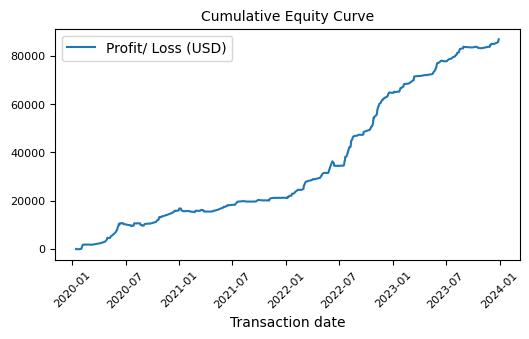

In [18]:
#creating the cumulative PNL plot

cum_plot_data = trade_list[['Transaction date', 'Profit/ Loss (USD)']].dropna()
cum_plot = cum_plot_data.set_index('Transaction date').sort_index().cumsum()

plt.figure(figsize=(6,3))
ax = sns.lineplot(data=cum_plot)
plt.title('Cumulative Equity Curve', fontsize=10)
plt.tick_params(labelsize=8)
plt.xticks(rotation=45)

plt.show()

**4) Other EDA Indicators**

In [19]:
# Extracting only close price from various dataframes
start = df_list[0].loc[1, 'Date']
end = df_list[0].loc[df.index[-1], 'Date']

df_close_price = []
df_close_price.append(df_list[0]['Date'].to_list())
bench_list = ['DX-Y.NYB', '^TNX']

for close_price in df_list:
  price = close_price['Close'].to_list()
  df_close_price.append(price)

for ticker in bench_list:
  bench_close = yf.download(ticker, start=start, end=end, interval=interval, auto_adjust=True, back_adjust=True, progress=False)['Close']
  df_close_price.append(bench_close)

# putting everything to a dataframe, adding the column headers
all_df = pd.DataFrame(df_close_price).T
# all_df.columns = ['Date', 'TQQQ', 'SQQQ', 'SPXL', 'SPXS', 'TZA', 'TNA', 'SOXL', 'SOXS', 'FAS', 'FAZ', 'LABD', 'LABU', 'EDZ', 'EDC', 'USD Index', '10-yr T.Note']

# changing dataframe from object to numeric for plotting heatmap
for col in all_df.columns[1:]:
    all_df[col] = pd.to_numeric(all_df[col], errors='coerce')


In [20]:
# plt.figure(figsize=(30,10))
# plt.title('Heatmap for 3x Leveraged ETF and Benchmarking Index')
# mask = np.triu(np.ones_like(all_df.corr())) #--> add syntax mask=mask to produce diagonal heatmap
# sns.heatmap(all_df.corr(), annot = True, vmin=-1, vmax=1, center=0, cmap='coolwarm') #--> mask=mask to create diagonal heatmap

**5) Calculating the Sharpe Ratio**

In [21]:
from typing import Optional
from math import sqrt

In [22]:
def compute_sharpe_ratio(return_series: pd.Series, annualized_factor: int=252) -> Optional[float]:
    mean_return: float = return_series.mean()
    return_std: float = return_series.std()
    if return_std == 0:
        logger.warning('Return std is 0!')
        return
    sharpe: float = return_series.mean() / return_series.std() * sqrt(annualized_factor)
    return sharpe